In [11]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline


In [12]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [13]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5

connect_to_db = 'postgresql+psycopg2://' + \
                creds['username'] + ':' + creds['password'] + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [14]:
original_df = pd.read_sql_query("""select * from ml_prep.last_bid_usd_with_bid 
                          where slider_start_usd < 100000 and
                             slider_min_usd < 100000 and 
                             slider_max_usd < 100000""", con)
original_df.head()

event_id            event_time  \
0  77c8d211-9355-4a99-ad42-a5b667c5cc94  2017-10-27T17:52:04Z   
1  f4b57666-eebe-4e33-afd1-f01f0e45ce79  2017-10-26T00:01:52Z   
2  7927efb2-457f-4ebc-a90c-64d8806b8015  2017-10-21T21:21:07Z   
3  cb790640-6e1b-4c13-9c23-8b3cfe86a751  2017-09-12T15:04:43Z   
4  b4de4d27-2842-4b7a-ba6d-88220668943f  2017-11-07T01:26:26Z   

                           request_id  partner_id origin destination  \
0  yYlrPi6CbQOKT9cv7OEiuiwcfwzdSTFYXT         179    YVR         SYD   
1  Vn0RQDO3QnfzyD1CY7z4s3DkB061wFSTPe          35    BNE         LAX   
2  rMiaYP18FOeJAdmJvz4w8YO8CF1i4sUI2j         179    ZIH         YYZ   
3  FMX119MVvNNSeuq9LqTl1cMQjAyHcpZ9Ez         179    FCO         YYZ   
4  YUnZblpdu6Q64FAdorisdtHPNngbYXqAOP         179    YYZ         EZE   

   flight_number departure_date departure_time currency   ...    \
0             33     2017-11-01          23:45      CAD   ...     
1              9     2017-10-29          21:30      AUD   ...     
2            945     2018-02-03          15:30      CAD   ...     
3            891     2017-10-30          10:00      USD   ...     
4             92     2017-12-09          23:45      CAD   ...     

  instant_upgrade_eligibility_reason slider_step  duration  distance  \
0           INSTANT_UPGRADE_DISABLED           5       940      7776   
1           INSTANT_UPGRADE_DISABLED           5       785      7177   
2           INSTANT_UPGRADE_DISABLED           5       285      2208   
3           INSTANT_UPGRADE_DISABLED           5       585      4407   
4           INSTANT_UPGRADE_DISABLED           5       730      5590   

  distance_unit equipment slider_max_usd slider_min_usd slider_start_usd  \
0            mi       77L         1155.0          695.0            898.0   
1            mi       77W         1440.0          375.0           1134.0   
2            mi       319          475.0          206.0            261.0   
3            mi       333         1652.0          743.0            991.0   
4            mi       77W         1786.0          783.0            979.0   

  has_bid  
0    True  
1    True  
2    True  
3    True  
4    True  

[5 rows x 32 columns]

In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874014 entries, 0 to 874013
Data columns (total 32 columns):
event_id                              874014 non-null object
event_time                            874014 non-null object
request_id                            874014 non-null object
partner_id                            874014 non-null int64
origin                                874014 non-null object
destination                           874014 non-null object
flight_number                         874014 non-null int64
departure_date                        874014 non-null object
departure_time                        874014 non-null object
currency                              874014 non-null object
pnr                                   874014 non-null object
language                              874014 non-null object
pax                                   874014 non-null int64
eligibility                           874014 non-null bool
point_of_sale                         87

In [15]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [16]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration  \
count  874014.000000  874014.000000  874014.000000  874014.000000   
mean      134.146860     990.885219       1.500836     338.028576   
std        66.686228    1702.086515       0.804810     250.117661   
min        35.000000       1.000000       1.000000      24.000000   
25%        35.000000     126.000000       1.000000     135.000000   
50%       179.000000     568.000000       1.000000     260.000000   
75%       179.000000     888.000000       2.000000     480.000000   
max       179.000000    8987.000000       9.000000    1237.000000   

            distance  slider_max_usd  slider_min_usd  slider_start_usd  
count  874014.000000   874014.000000   874014.000000     874014.000000  
mean     2627.814339      773.556643      348.775136        508.342306  
std      2244.771296      656.714305      337.102323        523.352862  
min        33.000000      150.000000       42.000000         76.000000  
25%       827.000000      385.000000      137.000000        216.000000  
50%      2019.000000      559.000000      240.000000        352.000000  
75%      3946.000000      904.000000      410.000000        588.000000  
max      9676.000000     5525.000000     3113.000000       4802.000000

In [17]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 874014  874014      874014         874014   
unique                370230     177         176            435   
top     2017-11-09T19:10:45Z     YYZ         YYZ     2017-11-17   
freq                      21  170466      184328          11790   

       departure_time currency language point_of_sale    channel_source  \
count          874014   874014   874014        874014            874014   
unique            248       21       10            68              3878   
top             08:00      CAD       en            CA  PRE_TRAVEL_EMAIL   
freq            16810   490429   743136        476494            391522   

       carrier_code fare_class from_cabin upgrade_type equipment  
count        874014     874014     874014       874014    874014  
unique            2         20          2            4        20  
top              AC          K    ECONOMY     BUSINESS       73H  
freq         601776     221954     843444       481612    200111

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874014 entries, 0 to 874013
Data columns (total 24 columns):
event_time          874014 non-null object
partner_id          874014 non-null int64
origin              874014 non-null object
destination         874014 non-null object
flight_number       874014 non-null int64
departure_date      874014 non-null object
departure_time      874014 non-null object
currency            874014 non-null object
language            874014 non-null object
pax                 874014 non-null int64
eligibility         874014 non-null bool
point_of_sale       874014 non-null object
channel_source      874014 non-null object
carrier_code        874014 non-null object
fare_class          874014 non-null object
from_cabin          874014 non-null object
upgrade_type        874014 non-null object
duration            874014 non-null int64
distance            874014 non-null int64
equipment           874014 non-null object
slider_max_usd      874014 non-null 

In [16]:
df179 = df[df["partner_id"] == 179].copy()
df179.drop(["partner_id", "eligibility"], axis = 1, inplace = True)
df179.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 0 to 874013
Data columns (total 22 columns):
event_time          601776 non-null object
origin              601776 non-null object
destination         601776 non-null object
flight_number       601776 non-null int64
departure_date      601776 non-null object
departure_time      601776 non-null object
currency            601776 non-null object
language            601776 non-null object
pax                 601776 non-null int64
point_of_sale       601776 non-null object
channel_source      601776 non-null object
carrier_code        601776 non-null object
fare_class          601776 non-null object
from_cabin          601776 non-null object
upgrade_type        601776 non-null object
duration            601776 non-null int64
distance            601776 non-null int64
equipment           601776 non-null object
slider_max_usd      601776 non-null float64
slider_min_usd      601776 non-null float64
slider_start_usd    601776 non-

In [ ]:
#import missingno as msno
# Nullity or missing values by columns
#msno.bar(df)

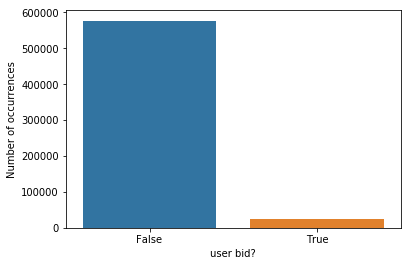

Has_bid percentage: 4.32%


In [19]:
#What is the distribution of has bid
sns.countplot(df179.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df179["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

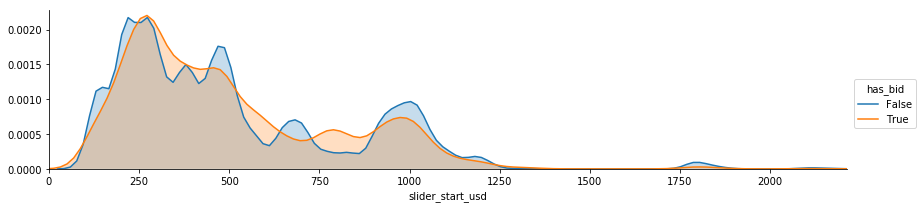

In [20]:
plot_distribution( df179 , var = 'slider_start_usd' , target = 'has_bid' )

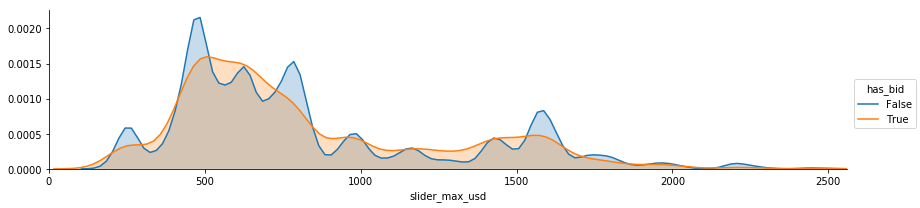

In [21]:
plot_distribution( df179 , var = 'slider_max_usd' , target = 'has_bid' )

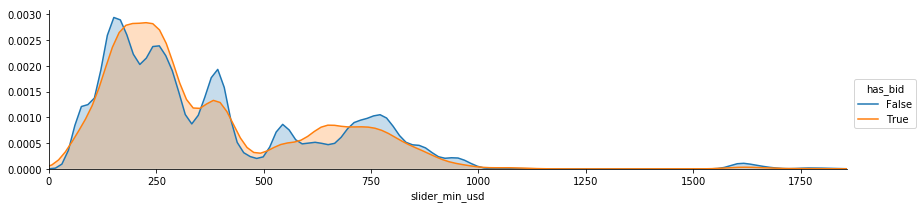

In [22]:
plot_distribution( df179 , var = 'slider_min_usd' , target = 'has_bid' )

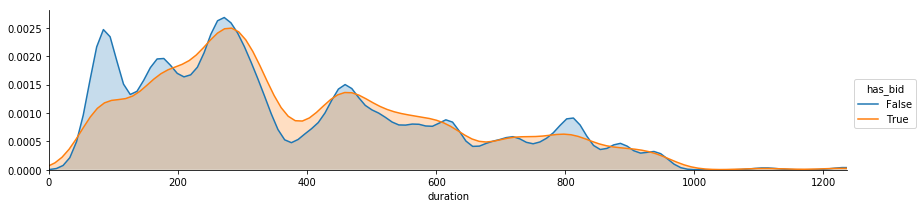

In [23]:
plot_distribution( df179 , var = 'duration' , target = 'has_bid' )

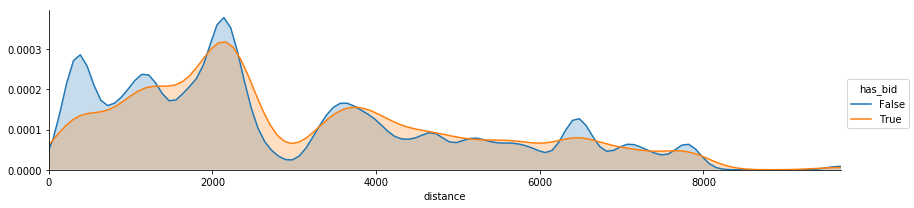

In [24]:
plot_distribution( df179 , var = 'distance' , target = 'has_bid' )

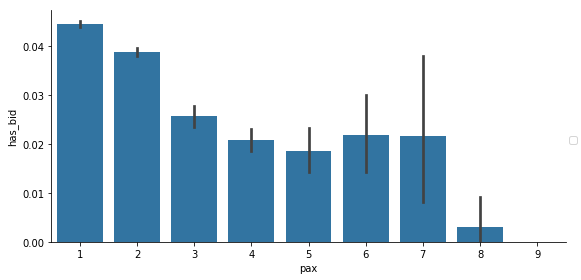

In [25]:
plot_categories( df179 , cat = 'pax' , target = 'has_bid' )

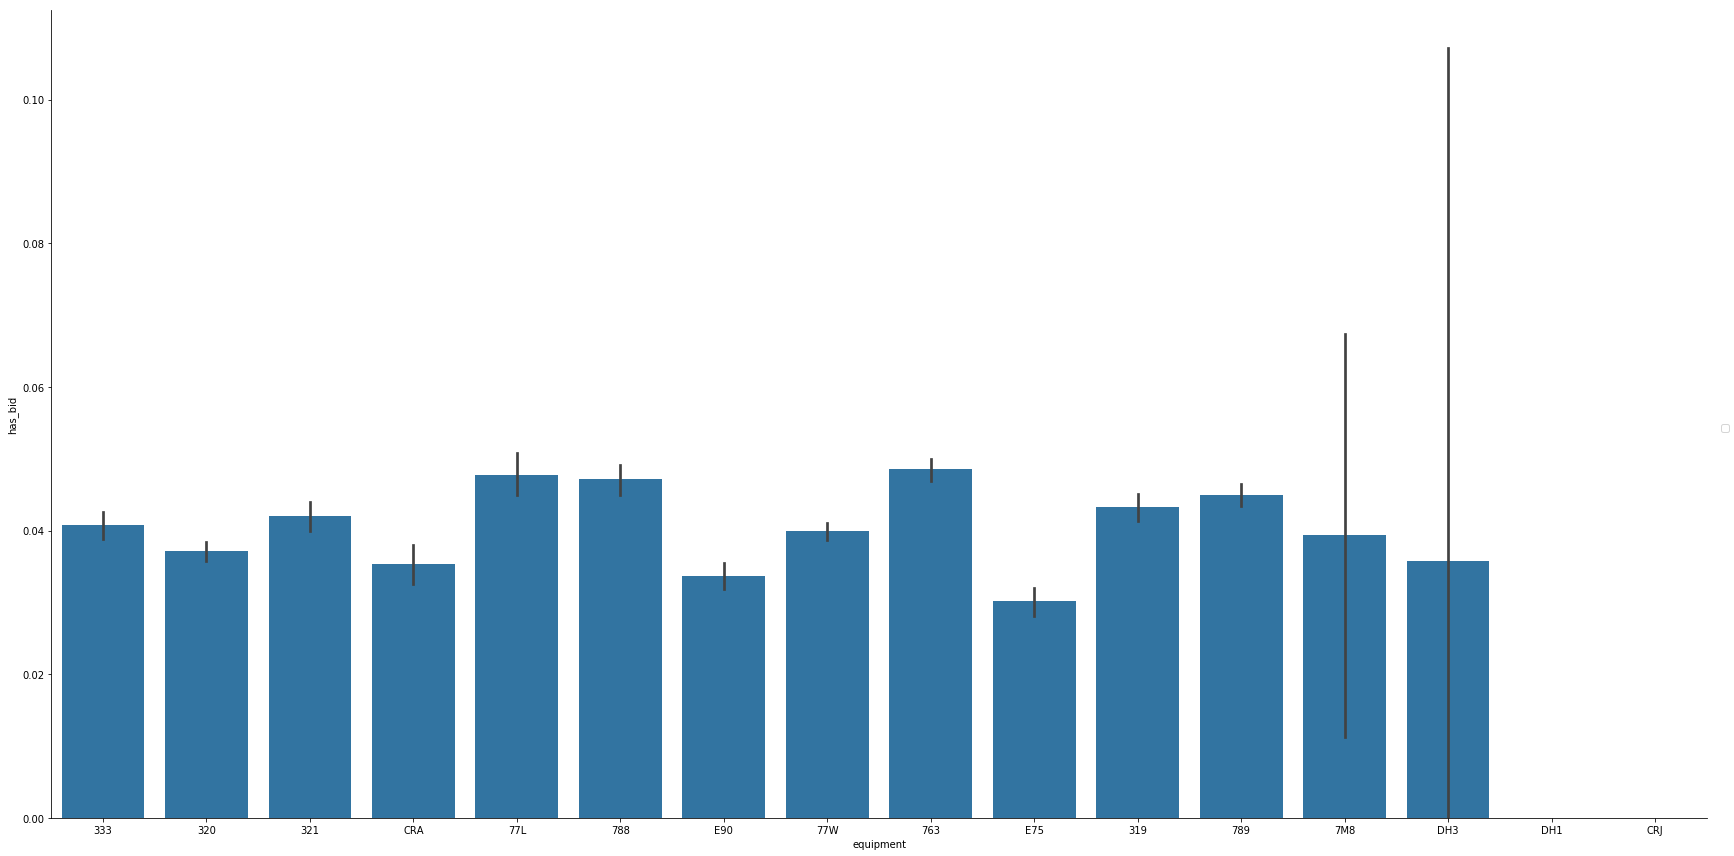

In [26]:
plot_categories( df179 , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

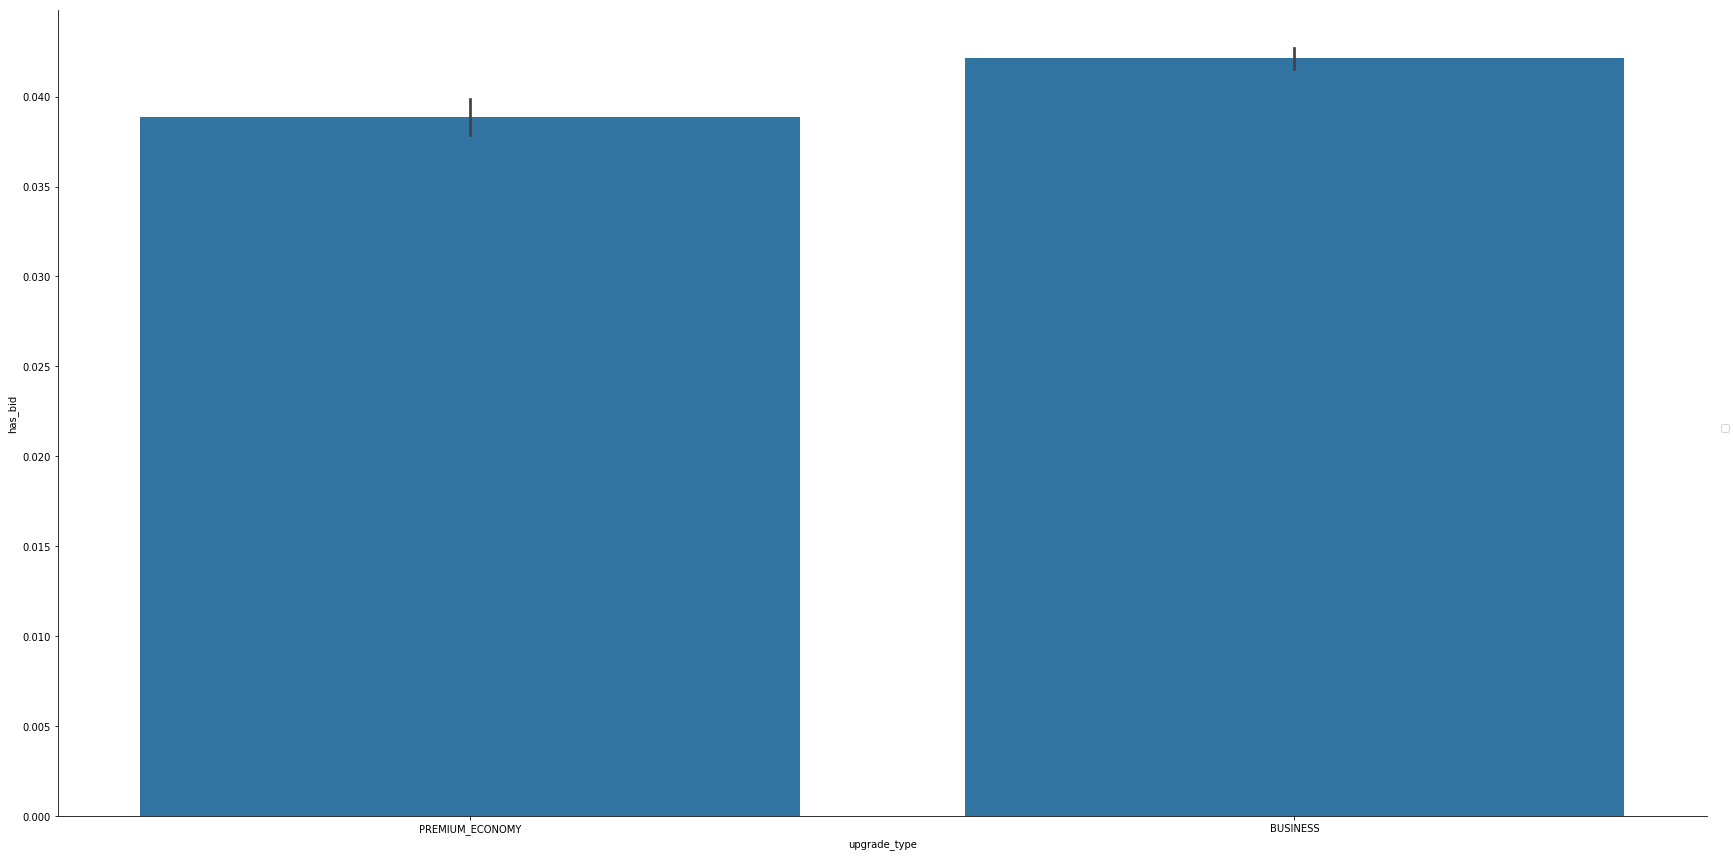

In [27]:
plot_categories( df179 , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

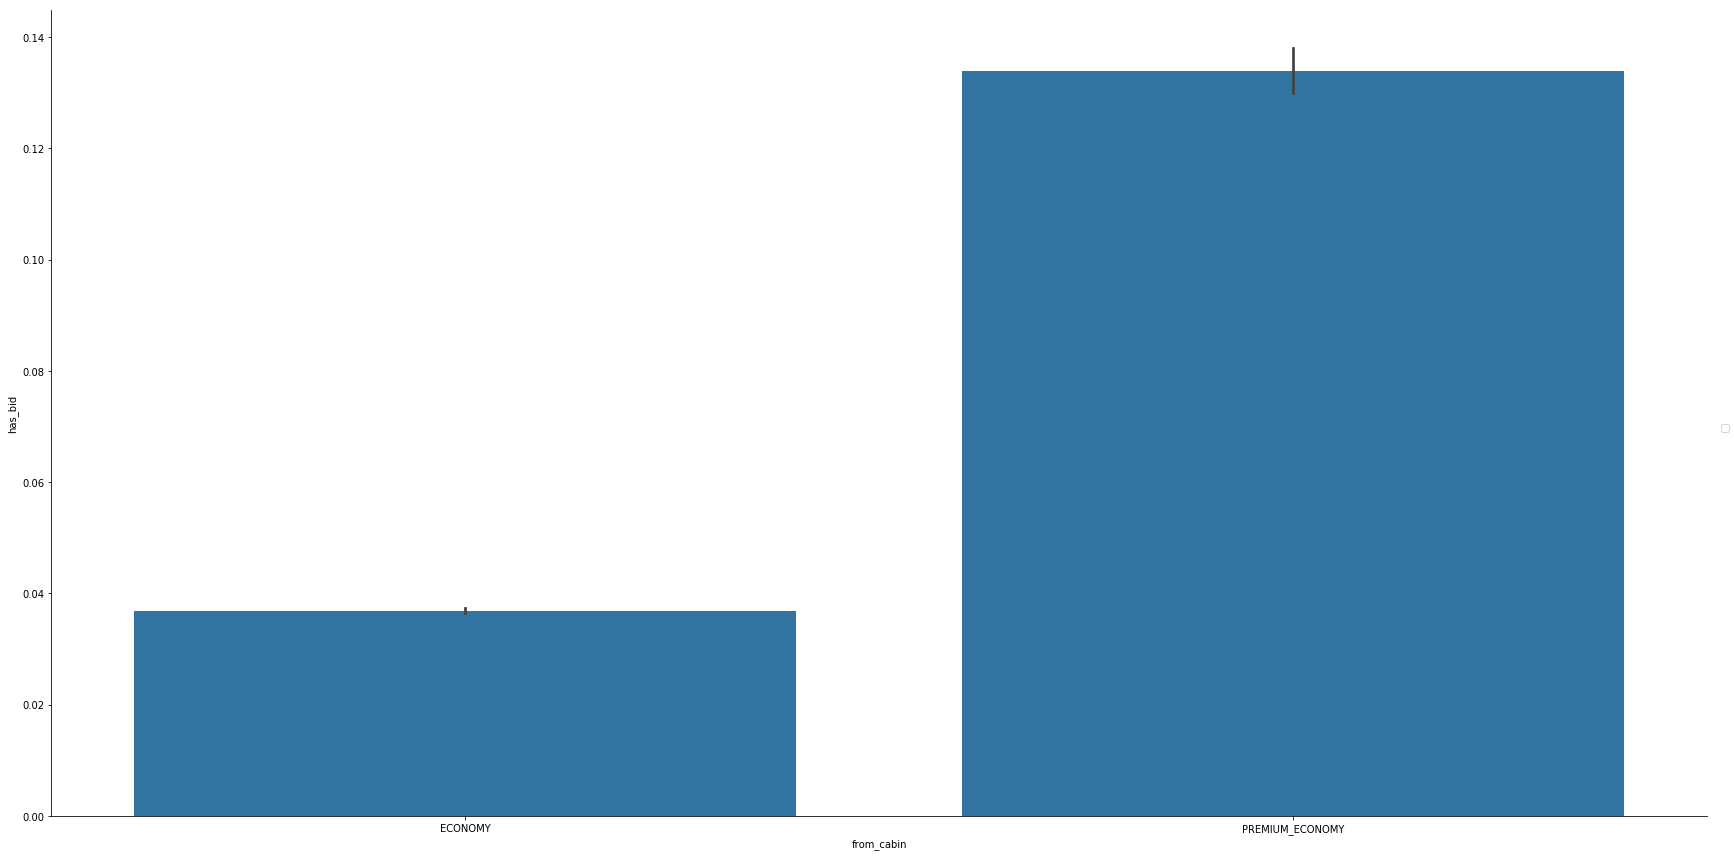

In [28]:
plot_categories( df179 , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

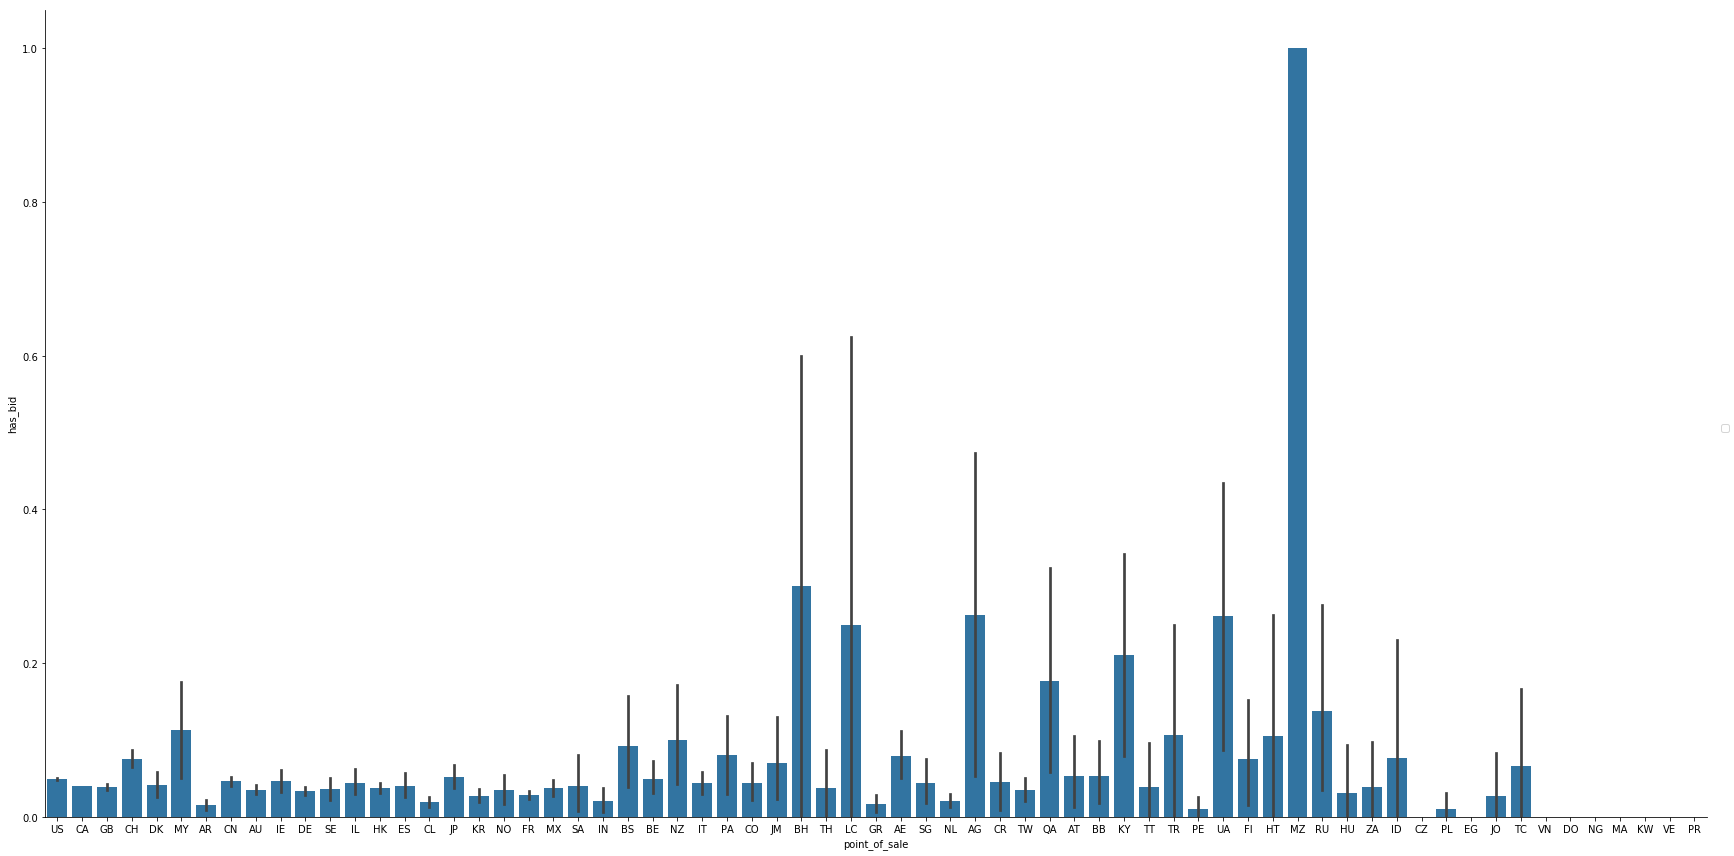

In [29]:
plot_categories( df179 , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

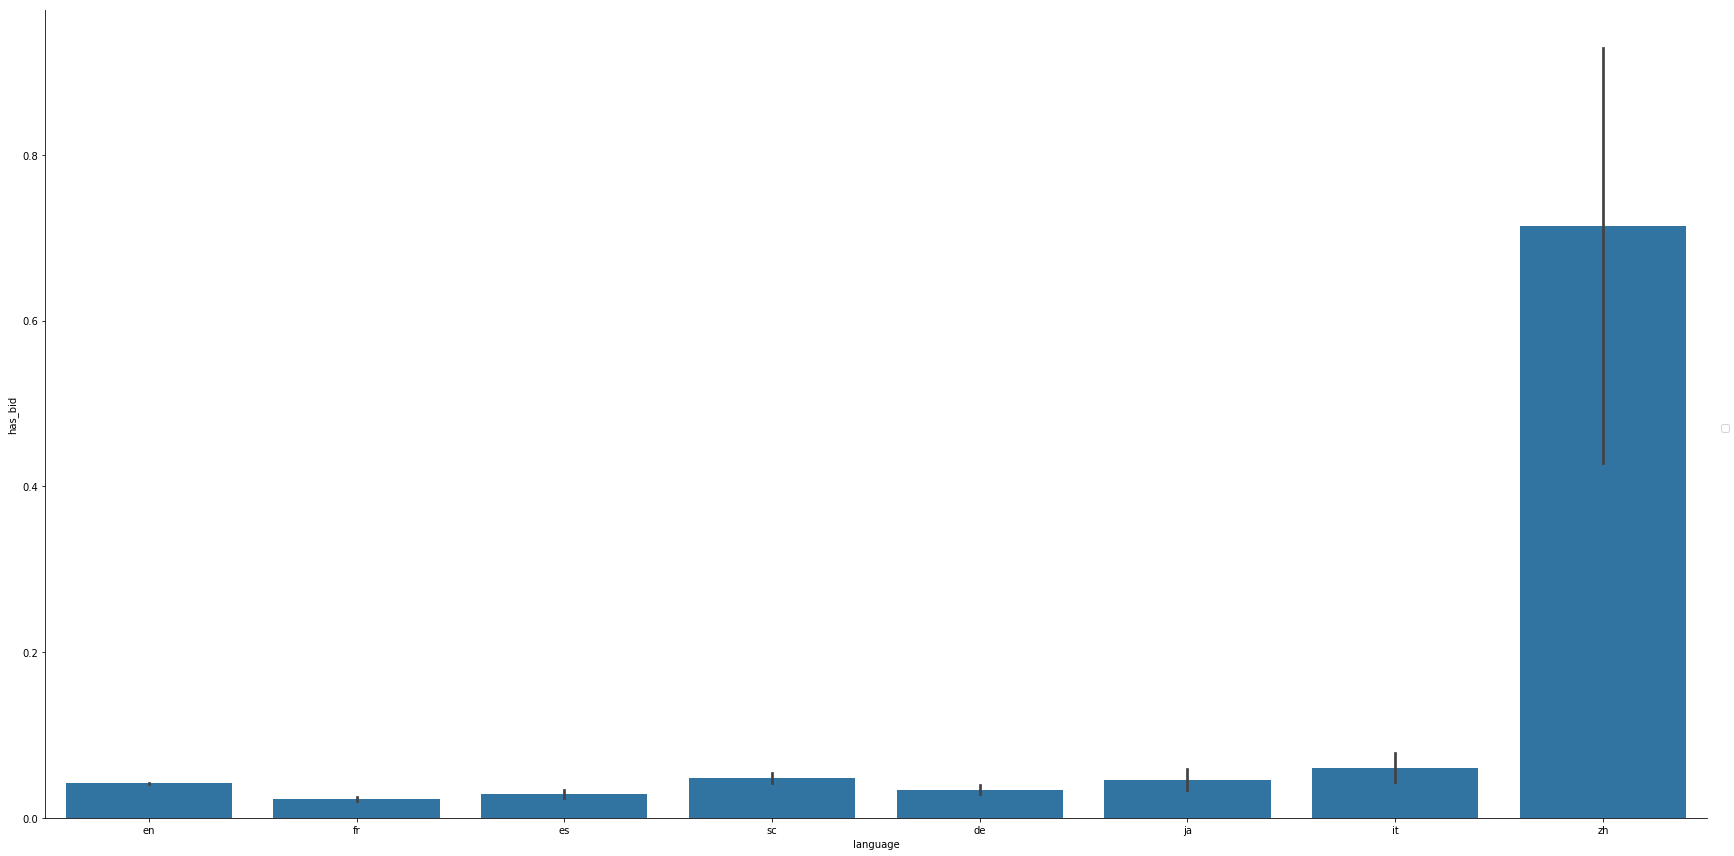

In [30]:
plot_categories( df179 , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [17]:
df_nonNas = df179.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")

#fill distance_amount and duration with means
#df_nonNas['distance_amount'] = df_nonNas['distance_amount'].fillna((df_nonNas['distance_amount'].mean()))
#df_nonNas['duration'] = df_nonNas['duration'].fillna((df_nonNas['duration'].mean()))
#don't show good results. maybe we can replace it with a better idea, like if the flag has_bid is true, we know that the flight
#probably will be long...
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 0 to 874013
Data columns (total 22 columns):
event_time          601776 non-null object
origin              601776 non-null object
destination         601776 non-null object
flight_number       601776 non-null float32
departure_date      601776 non-null object
departure_time      601776 non-null object
currency            601776 non-null object
language            601776 non-null object
pax                 601776 non-null float32
point_of_sale       601776 non-null object
channel_source      601776 non-null object
carrier_code        601776 non-null object
fare_class          601776 non-null object
from_cabin          601776 non-null object
upgrade_type        601776 non-null object
duration            601776 non-null float32
distance            601776 non-null float32
equipment           601776 non-null object
slider_max_usd      601776 non-null float32
slider_min_usd      601776 non-null float32
slider_start_usd    601

### Prepare dataset

In [21]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [22]:
columns_cat = ["origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [17]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 0 to 874013
Data columns (total 22 columns):
event_time          601776 non-null object
origin              601776 non-null int64
destination         601776 non-null int64
flight_number       601776 non-null int64
departure_date      601776 non-null object
departure_time      601776 non-null int64
currency            601776 non-null int64
language            601776 non-null int64
pax                 601776 non-null float32
point_of_sale       601776 non-null int64
channel_source      601776 non-null int64
carrier_code        601776 non-null int64
fare_class          601776 non-null int64
from_cabin          601776 non-null int64
upgrade_type        601776 non-null int64
duration            601776 non-null float32
distance            601776 non-null float32
equipment           601776 non-null int64
slider_max_usd      601776 non-null float32
slider_min_usd      601776 non-null float32
slider_start_usd    601776 non-null f

## Create a model and evaluation

In [19]:
#Function utils
random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


### Feature engineering

* considering feature engineering from data exploration 2: origin-destination pair, days before departure.
* eval undersampling again, maybe removing features that don't have bid and 

#### Ideas explored:


* new fields from data exploration3 (upgrade_Type, from_cabin, language, point_of_sale) are valuable ?
* try make a pair with from_cabin and upgrade_type

In [18]:

print("Before undersampling and feature engineering")
do_train(train_df_fact.drop(["departure_date","event_time"], axis=1))


Before undersampling and feature engineering

Fold  1
Accuracy = 94.91
AUC = 0.6448085726115216

Fold  2
Accuracy = 94.9
AUC = 0.6457990943160894

Fold  3
Accuracy = 94.9
AUC = 0.6421662047652092

Fold  4
Accuracy = 94.83
AUC = 0.6401793017044998

Fold  5
Accuracy = 95.0
AUC = 0.6453933375412902


In [19]:
train_df_fact_010 = do_undersampling(train_df_fact, 'has_bid', 0.10)
print("After undersampling 0.10%")
do_train(train_df_fact_010.drop(["departure_date","event_time"], axis=1))

train_df_fact_015 = do_undersampling(train_df_fact, 'has_bid', 0.15)
print("After undersampling 0.15%")
do_train(train_df_fact_015.drop(["departure_date","event_time"], axis=1))

train_df_fact_020 = do_undersampling(train_df_fact, 'has_bid', 0.20)
print("After undersampling 0.20%")
do_train(train_df_fact_020.drop(["departure_date","event_time"], axis=1))


Rate to undersample records with target=0: 0.388553073390758
Number of records with target=0 after undersampling: 224144
After undersampling 0.10%

Fold  1
Accuracy = 87.76
AUC = 0.6610946538382679

Fold  2
Accuracy = 88.09
AUC = 0.6576844793451126

Fold  3
Accuracy = 88.34
AUC = 0.6604051864144831

Fold  4
Accuracy = 87.99
AUC = 0.6651085500421743

Fold  5
Accuracy = 88.32
AUC = 0.6560382168580037
Rate to undersample records with target=0: 0.24464452769047731
Number of records with target=0 after undersampling: 141128
After undersampling 0.15%

Fold  1
Accuracy = 82.61
AUC = 0.6652348171364832

Fold  2
Accuracy = 82.71
AUC = 0.6612962451982591

Fold  3
Accuracy = 82.8
AUC = 0.6674737881002509

Fold  4
Accuracy = 82.73
AUC = 0.6651614762816423

Fold  5
Accuracy = 83.13
AUC = 0.6635421465582233
Rate to undersample records with target=0: 0.1726902548403369
Number of records with target=0 after undersampling: 99619
After undersampling 0.20%

Fold  1
Accuracy = 77.46
AUC = 0.66105739089164

In [20]:
#It seems that 0.15% - 0.20% is the optimal undersampling..

In [23]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = do_undersampling(train_df2, 'has_bid', 0.20)

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


Rate to undersample records with target=0: 0.1726902548403369
Number of records with target=0 after undersampling: 99619


In [23]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124524 entries, 0 to 124523
Data columns (total 24 columns):
event_time               124524 non-null object
origin                   124524 non-null int64
destination              124524 non-null int64
flight_number            124524 non-null int64
departure_date           124524 non-null object
departure_time           124524 non-null int64
currency                 124524 non-null int64
language                 124524 non-null int64
pax                      124524 non-null float32
point_of_sale            124524 non-null int64
channel_source           124524 non-null int64
carrier_code             124524 non-null int64
fare_class               124524 non-null int64
from_cabin               124524 non-null int64
upgrade_type             124524 non-null int64
duration                 124524 non-null float32
distance                 124524 non-null float32
equipment                124524 non-null int64
slider_max_usd           124524 non

In [24]:
print("It seems that we lost AUC from feature engineering 2.")
do_train(train_df_fact2.drop(["departure_date","event_time"], axis=1))

It seems that we lost AUC from feature engineering 2. Lets drop new fields

Fold  1
Accuracy = 79.13
AUC = 0.6938195754770341

Fold  2
Accuracy = 79.84
AUC = 0.6954249178705465

Fold  3
Accuracy = 79.27
AUC = 0.6965028948854778

Fold  4
Accuracy = 79.46
AUC = 0.6966087992072896

Fold  5
Accuracy = 79.04
AUC = 0.6965115147937719


In [26]:
print("It seems that we lost AUC from feature engineering 2. Lets drop new fields")
do_train(train_df_fact2.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1))

It seems that we lost AUC from feature engineering 2. Lets drop new fields

Fold  1
Accuracy = 79.07
AUC = 0.6907898958727687

Fold  2
Accuracy = 79.48
AUC = 0.6952973207225578

Fold  3
Accuracy = 79.06
AUC = 0.6964884807128277

Fold  4
Accuracy = 79.59
AUC = 0.6958488456305473

Fold  5
Accuracy = 79.02
AUC = 0.6950062804505175


In [27]:
new_fields = ["language", "upgrade_type", "from_cabin", "point_of_sale"]
for field in new_fields:
    print("Dropping field {}".format(field))
    do_train(train_df_fact2.drop(["departure_date","event_time"], axis=1).drop([field], axis=1))

Dropping field language

Fold  1
Accuracy = 79.08
AUC = 0.6926551614396919

Fold  2
Accuracy = 79.58
AUC = 0.6968407101508726

Fold  3
Accuracy = 79.18
AUC = 0.696145398422521

Fold  4
Accuracy = 79.46
AUC = 0.6986368470971828

Fold  5
Accuracy = 79.0
AUC = 0.6954554543844337
Dropping field upgrade_type

Fold  1
Accuracy = 79.14
AUC = 0.6923758213260977

Fold  2
Accuracy = 79.69
AUC = 0.6958146949888013

Fold  3
Accuracy = 79.24
AUC = 0.6967046183588735

Fold  4
Accuracy = 79.55
AUC = 0.6979892800253732

Fold  5
Accuracy = 79.13
AUC = 0.6964395135210516
Dropping field from_cabin

Fold  1
Accuracy = 79.23
AUC = 0.6917263521683411

Fold  2
Accuracy = 79.68
AUC = 0.6924805506972102

Fold  3
Accuracy = 79.12
AUC = 0.6958796830173046

Fold  4
Accuracy = 79.34
AUC = 0.6974635841057917

Fold  5
Accuracy = 78.97
AUC = 0.6954742937323326
Dropping field point_of_sale

Fold  1
Accuracy = 79.12
AUC = 0.6921025244229663

Fold  2
Accuracy = 79.64
AUC = 0.6950913532008431

Fold  3
Accuracy = 79.34
AU

In [28]:
#removing new fields didn't help the model, neither degrade, so we can drop them.

In [58]:
#Try to undersampling by a known factor to long days before departure
train_df3 = train_df2.copy()

train_df3["event_time"] = train_df3["event_time"].astype('datetime64[ns]')
train_df3["event_time"] = train_df3["event_time"].apply(lambda x: x.date() )
train_df3["departure_date"] = train_df3["departure_date"].astype('datetime64[ns]')
train_df3["departure_date"] = train_df3["departure_date"].apply(lambda x: x.date() )
train_df3["days_before_departure"] = train_df3["departure_date"] - train_df3["event_time"]
train_df3["days_before_departure"] = train_df3["days_before_departure"].apply(lambda x: x.days)
train_df3["destination_origin"] = train_df3["destination"]  + "-" + train_df3["origin"]

train_df3.drop(train_df3[(train_df3["days_before_departure"] > 50)].index)

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df3_fact = factorize_df(train_df3, columns_cat2) 

In [ ]:
#Doesn't increase the AUC... Lets maintain the original random undersampling.

In [59]:
#do_train(train_df3_fact.drop(["departure_date","event_time"], axis = 1))
train_df3_fact_020 = do_undersampling(train_df3_fact, 'has_bid', 0.20)
do_train(train_df3_fact_020.drop(["departure_date","event_time"], axis = 1))

Rate to undersample records with target=0: 0.1726902548403369
Number of records with target=0 after undersampling: 99619

Fold  1
Accuracy = 79.18
AUC = 0.6924049916315109

Fold  2
Accuracy = 79.57
AUC = 0.6940986413594271

Fold  3
Accuracy = 79.2
AUC = 0.6978907673711815

Fold  4
Accuracy = 79.44
AUC = 0.6986853814212022

Fold  5
Accuracy = 78.87
AUC = 0.695132866241732


In [60]:
#Try to undersampling by a known factor to long days before departure
train_df3 = train_df2.copy()

train_df3["event_time"] = train_df3["event_time"].astype('datetime64[ns]')
train_df3["event_time"] = train_df3["event_time"].apply(lambda x: x.date() )
train_df3["departure_date"] = train_df3["departure_date"].astype('datetime64[ns]')
train_df3["departure_date"] = train_df3["departure_date"].apply(lambda x: x.date() )
train_df3["days_before_departure"] = train_df3["departure_date"] - train_df3["event_time"]
train_df3["days_before_departure"] = train_df3["days_before_departure"].apply(lambda x: x.days)
train_df3["destination_origin"] = train_df3["destination"]  + "-" + train_df3["origin"]
train_df3["from_cabin_upgrade_type"] = train_df3["from_cabin"]  + "-" + train_df3["upgrade_type"]


columns_cat2 = ["destination_origin", "from_cabin_upgrade_type", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df3_fact = factorize_df(train_df3, columns_cat2) 

In [10]:
#do_train(train_df3_fact.drop(["departure_date","event_time"], axis = 1))
train_df3_fact_020 = do_undersampling(train_df3_fact, 'has_bid', 0.20)
do_train(train_df3_fact_020.drop(["departure_date","event_time", "from_cabin", "upgrade_type"], axis = 1))

NameError: name 'do_undersampling' is not defined

## Conslusions

* New evaluation with new training data decreased the test AUC for 0.70
* New Fields didn't increase the model performance.



In [25]:
do_train(train_df_fact2.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1))
do_train(train_df_fact2.drop(["origin", "destination", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1))



Fold  1
Accuracy = 78.98
AUC = 0.686033411613522

Fold  2
Accuracy = 79.3
AUC = 0.6997164725858633

Fold  3
Accuracy = 79.22
AUC = 0.6973349099090727

Fold  4
Accuracy = 79.41
AUC = 0.6994270626582668

Fold  5
Accuracy = 79.05
AUC = 0.6987032056846042

Fold  1
Accuracy = 79.25
AUC = 0.6913726986655163

Fold  2
Accuracy = 79.73
AUC = 0.7035760806260669

Fold  3
Accuracy = 79.32
AUC = 0.7028593351817847

Fold  4
Accuracy = 79.51
AUC = 0.7053028774137114

Fold  5
Accuracy = 79.24
AUC = 0.6997876177847451


In [28]:
df_to_export = train_df2_020.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1)

df_to_export.to_csv("last_bid_data_exploration_3_no_fact.csv", header=True, index=False)

In [29]:
import boto3
boto3.Session().resource('s3').Bucket("pg-ml-repository").Object('sagemaker/data-exploration-artifacts/last_bid_data_exploration_3_no_fact.csv').upload_file('last_bid_data_exploration_3_no_fact.csv')
